In [1]:
# Importing the dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,recall_score,precision_score

import nltk
import re

import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

# ensure tensorflow (which provides keras) is installed in the notebook environment
%pip install -q tensorflow

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, GRU, Bidirectional

import warnings
warnings.filterwarnings('ignore')  # To ignore warnings


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
train_data = pd.read_csv("/Users/shamimkhan/Downloads/training.csv") # Importing the train dataset
test_data = pd.read_csv("/Users/shamimkhan/Downloads/testing.csv")   # Importing the test dataset
validation_data = pd.read_csv("/Users/shamimkhan/Downloads/validation.csv")  # Importing the validation dataset

In [4]:
print("Train data :\n",train_data.head(),"\n")  # Printing the train dataset
print("Test data :\n",test_data.head(),"\n")   # Printing the test dataset
print("Validation data :\n",validation_data.head(),"\n")  # Printing the validation dataset


Train data :
                                                 text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3 

Test data :
                                                 text  label
0  im feeling rather rotten so im not very ambiti...      0
1          im updating my blog because i feel shitty      0
2  i never make her separate from me because i do...      0
3  i left with my bouquet of red and yellow tulip...      1
4    i was feeling a little vain when i did this one      0 

Validation data :
                                                 text  label
0  im feeling quite sad and sorry for myself but ...      0
1  i feel like i am still looking at a blank canv...      0
2                     i feel like a faithful serva

In [5]:
print("Train Data shape: ",train_data.shape) #Printing the shape train data
print("Test Data shape: ",test_data.shape) #Printing the shape test data
print("Validation Data shape: ",validation_data.shape) #Printing the shape validation data

Train Data shape:  (16000, 2)
Test Data shape:  (2000, 2)
Validation Data shape:  (2000, 2)


In [6]:
## Performing the EDA for the training dataset only
print(train_data.info()) # Information about training dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB
None


In [7]:
print(train_data.describe()) # Describeing the numerical data of training dataset

              label
count  16000.000000
mean       1.565937
std        1.501430
min        0.000000
25%        0.000000
50%        1.000000
75%        3.000000
max        5.000000


In [8]:
print(train_data.describe(include = 'O')) # Describeing the non-numerical data of training dataset
#print(train_data.duplicated().sum()) # Checking the duplicate values in training dataset

                                                     text
count                                               16000
unique                                              15969
top     i feel on the verge of tears from weariness i ...
freq                                                    2


In [9]:
train_data['label'].value_counts() # Counting the number of positive and negative sentiments of the training dataset


label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64

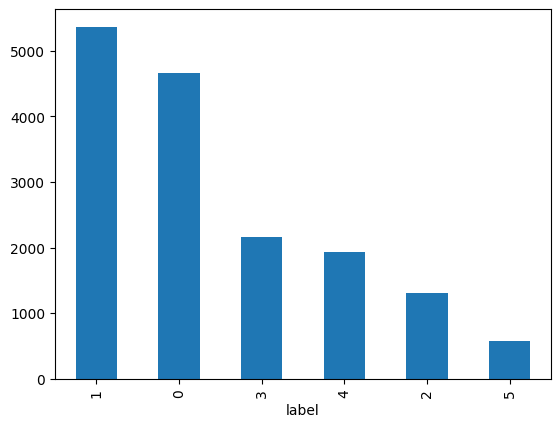

In [11]:
train_data['label'].value_counts().plot(kind = 'bar') # Plotting the bar plot for visualizing the countness of positive and negative labels
plt.show()

In [12]:
print("The Null value rows present in the trianing dataset is : ",train_data.isna().sum())    # Printing the null value present in the training dataset
print("The Duplicate rows present in the training dataset is : ",train_data.duplicated().sum())   # Printing the duplicated value present in the training dataset


The Null value rows present in the trianing dataset is :  text     0
label    0
dtype: int64
The Duplicate rows present in the training dataset is :  1


In [13]:
train_data.drop_duplicates(keep = 'first',inplace=True) # Dropping the duplicated values and keeping the first value in the dataset


In [14]:
print("Now the Duplicate rows present in the training dataset is : ",train_data.duplicated().sum()) # After Dropping now the duplicated values are zero
print("Now the shape of the training dataset is ",train_data.shape) # After dropping the duplicates the rows of the training data reduce

Now the Duplicate rows present in the training dataset is :  0
Now the shape of the training dataset is  (15999, 2)


In [15]:
## Perfoming the text preprocessing

nltk.download('stopwords')  # Downloading all the stopwords from the nltk library
pattern = re.compile('<.*?>')  # Pattern for removing the HTML tags
punctuation = string.punctuation   # Extracting all punctuation from the string library
ps = PorterStemmer()  # Creating a PorterStemmer object for the stemming purpose
tokenizer = Tokenizer() # Creating a Tokenizer object for representing the text into numeric form

def text_preprocess(text):

  text = re.sub(pattern,'',text)  # Removing the HTML tags using re library

  text = text.lower()  # Lower case all the character present in the text

  text = text.translate(str.maketrans('','',punctuation))   # Removing all the punctuation from the text

  text = text.split()    # word tokenize the text

  text = [ps.stem(word) for word in text if word not in stopwords.words('english')]  # Removing the stopwords from the text and stem each word

  return ' '.join(text)  # Join each word for the formation of clear text in string form

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shamimkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
processed_train_data = [text_preprocess(words) for words in train_data['text']]   # Applying the text pre-processing fuction to the text column of train dataset
processed_validation_data = [text_preprocess(words) for words in validation_data['text']]  # Applying the text pre-processing fuction to the text column of validation dataset
processed_test_data = [text_preprocess(words) for words in test_data['text']]   # Applying the text pre-processing fuction to the text column of test dataset


In [17]:
# Putting all the processed text of train data into a whole text. Then fit this whole text into the tokenizer for word embedding.

whole_text = ''

for i in processed_train_data:
  whole_text = whole_text + i


tokenizer.fit_on_texts([whole_text])
print(len(tokenizer.word_index))   # Printing the vocab size or the number of words present in the train data text. This is used as hyperparameter for the embedding layer.

20360


In [18]:
# In this cell the train processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_train_sequences = []

for i in processed_train_data:
  x_train_sequences.append(tokenizer.texts_to_sequences([i])[0])  # Each processed text is converted into sequences 


x_train_padseq = pad_sequences(x_train_sequences,maxlen = 50, padding = 'post')  # Each sequences are padded to have equal size.

x_train = np.array(x_train_padseq)
y_train = np.array(to_categorical(train_data['label']))  # One hot encoding the labels of the training dataset

In [19]:
# In this cell the validation processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_validation_sequences = []

for i in processed_validation_data:
  x_validation_sequences.append(tokenizer.texts_to_sequences([i])[0])    # Each processed text is converted into sequences


x_validation_padseq = pad_sequences(x_validation_sequences,maxlen = 50, padding = 'post')    # Each sequences are padded to have equal size.

x_validation = np.array(x_validation_padseq)
y_validation = np.array(to_categorical(validation_data['label']))

In [20]:
# In this cell the test processed texts are converted into respective numeric sequences which are further padded to have equal sizes.

x_test_sequences = []

for i in processed_test_data:
  x_test_sequences.append(tokenizer.texts_to_sequences([i])[0])     # Each processed text is converted into sequences


x_test_padseq = pad_sequences(x_test_sequences,maxlen = 50, padding = 'post')    # Each sequences are padded to have equal size.

x_test = np.array(x_test_padseq)
y_test = np.array(test_data['label'])

In [21]:
## Defining the hyperparameter of the embedding layer

vocab_size = 20360   # vocabulary size of the tokenizer
dim = 50             # Number of dense vector dimension required for the output
sent_length = 50    # The length of each sequence

In [22]:
## Bidirectional LSTM model

bidirectional_lstm_model = Sequential()

bidirectional_lstm_model.add(Embedding(vocab_size,dim,input_length = sent_length))
bidirectional_lstm_model.add(Bidirectional(LSTM(100)))
bidirectional_lstm_model.add(Dense(6,activation = 'softmax'))

bidirectional_lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

bidirectional_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Training the Bidirectional LSTM model

bidirectional_lstm_model_history = bidirectional_lstm_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.5852 - loss: 1.1238 - val_accuracy: 0.8025 - val_loss: 0.5874
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8822 - loss: 0.3389 - val_accuracy: 0.8700 - val_loss: 0.3561
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.9358 - loss: 0.1865 - val_accuracy: 0.8730 - val_loss: 0.3677
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9515 - loss: 0.1325 - val_accuracy: 0.8715 - val_loss: 0.4163
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9621 - loss: 0.1076 - val_accuracy: 0.8740 - val_loss: 0.3935


In [24]:
# LSTM model

lstm_model = Sequential()

lstm_model.add(Embedding(vocab_size,dim,input_length = sent_length))
lstm_model.add(LSTM(100,activation='relu'))
lstm_model.add(Dense(6,activation = 'softmax'))

lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Train the LSTM model

lstm_model_history = lstm_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.3625 - loss: 1.4439 - val_accuracy: 0.4385 - val_loss: 1.1980
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6270 - loss: 0.9304 - val_accuracy: 0.8065 - val_loss: 0.6175
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8297 - loss: 0.5356 - val_accuracy: 0.8370 - val_loss: 0.5077
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8989 - loss: 0.3176 - val_accuracy: 0.8580 - val_loss: 0.4355
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9074 - loss: 0.3170 - val_accuracy: 0.8505 - val_loss: 0.4815


In [26]:
# Bidirectional GRU model

bidirectional_gru_model = Sequential()

bidirectional_gru_model.add(Embedding(vocab_size,dim,input_length = sent_length))
bidirectional_gru_model.add(Bidirectional(GRU(100)))
bidirectional_gru_model.add(Dense(6,activation = 'softmax'))

bidirectional_gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

bidirectional_gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the bidirectional GRU model

bidirectional_gru_model_history = bidirectional_gru_model.fit(x = x_train, y = y_train, validation_data = (x_validation,y_validation), epochs = 5, batch_size = 32)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.6392 - loss: 0.9629 - val_accuracy: 0.8335 - val_loss: 0.4548
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.8997 - loss: 0.2812 - val_accuracy: 0.8940 - val_loss: 0.3029
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.9339 - loss: 0.1688 - val_accuracy: 0.8920 - val_loss: 0.3134
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9531 - loss: 0.1175 - val_accuracy: 0.8945 - val_loss: 0.3338
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.9671 - loss: 0.0881 - val_accuracy: 0.8875 - val_loss: 0.3840


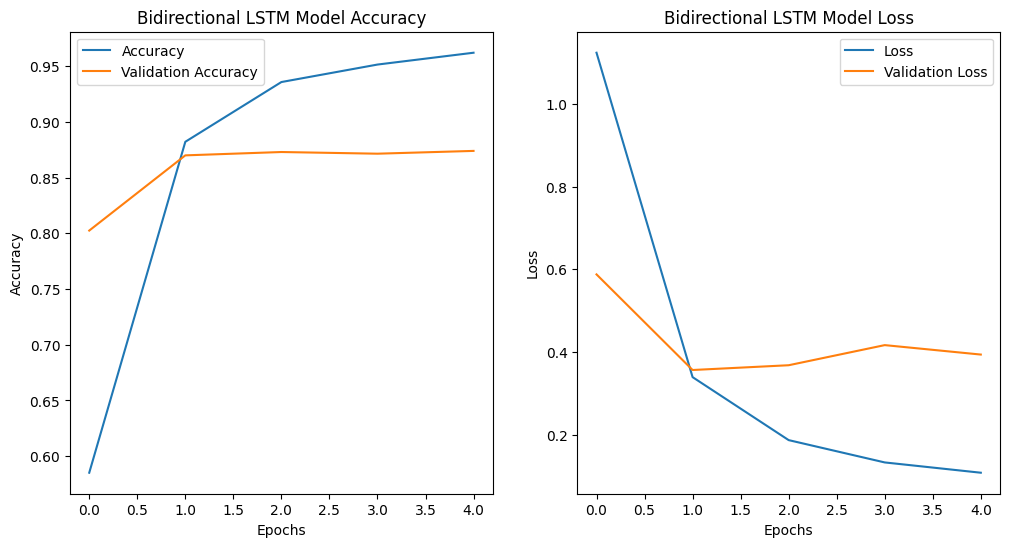

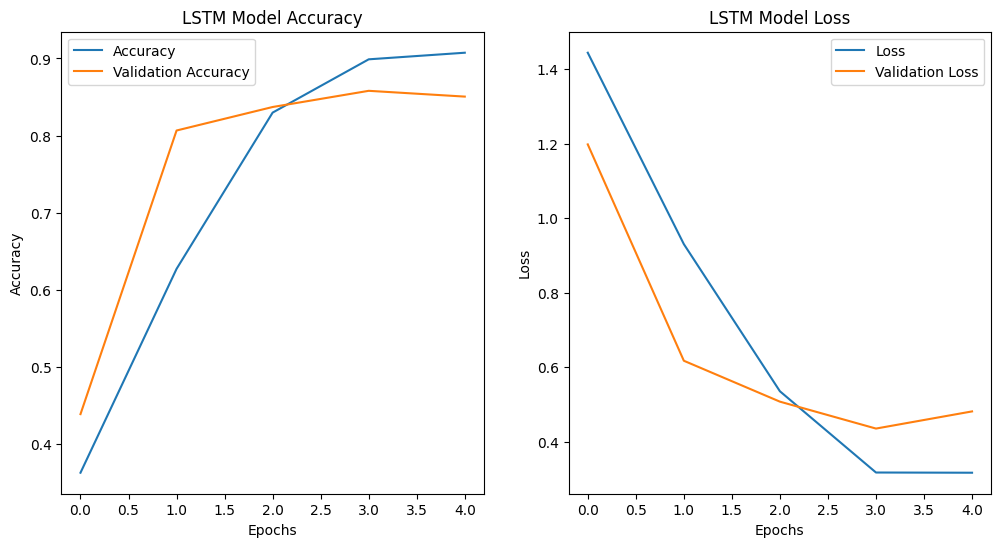

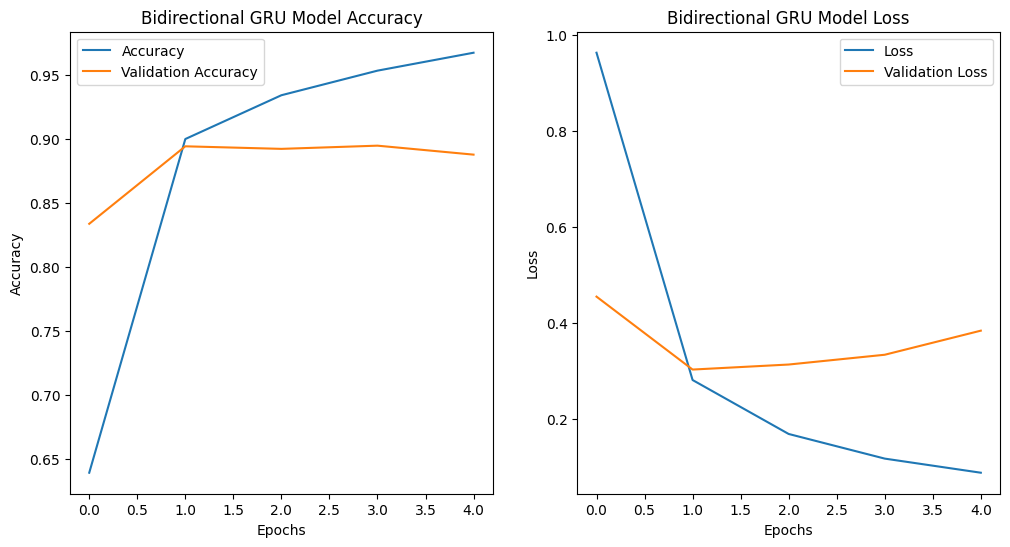

In [28]:
# Setting the figure size of the plot
plt.figure(figsize=(12,6))


# Plotting the accuracy plot of Bidirectional LSTM model
plt.subplot(1,2,1)
plt.title("Bidirectional LSTM Model Accuracy")
plt.plot(bidirectional_lstm_model_history.history['accuracy'],label='Accuracy')
plt.plot(bidirectional_lstm_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()


# Plotting the loss plot of Bidirectional LSTM model
plt.subplot(1,2,2)
plt.title("Bidirectional LSTM Model Loss")
plt.plot(bidirectional_lstm_model_history.history['loss'],label='Loss')
plt.plot(bidirectional_lstm_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the accuracy plot of LSTM model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("LSTM Model Accuracy")
plt.plot(lstm_model_history.history['accuracy'],label='Accuracy')
plt.plot(lstm_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the loss plot of LSTM model
plt.subplot(1,2,2)
plt.title("LSTM Model Loss")
plt.plot(lstm_model_history.history['loss'],label='Loss')
plt.plot(lstm_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plotting the accuracy plot of Bidirectional GRU model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Bidirectional GRU Model Accuracy")
plt.plot(bidirectional_gru_model_history.history['accuracy'],label='Accuracy')
plt.plot(bidirectional_gru_model_history.history['val_accuracy'],label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting the loss plot of Bidirectional GRU model
plt.subplot(1,2,2)
plt.title("Bidirectional GRU Model Loss")
plt.plot(bidirectional_gru_model_history.history['loss'],label='Loss')
plt.plot(bidirectional_gru_model_history.history['val_loss'],label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()


In [29]:
# Predicting the output of each model on test data for model evaluation
# ----------------------------------------------------------------------
y_pred_bilstm = bidirectional_lstm_model.predict(x_test)
y_pred_lstm = lstm_model.predict(x_test)
y_pred_bigru = bidirectional_gru_model.predict(x_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [30]:
# Converting the continuous output model into discrete classes
# ---------------------------------------------------------------------
y_pred_bilstm = np.array([np.argmax(x) for x in y_pred_bilstm])
y_pred_lstm = np.array([np.argmax(x) for x in y_pred_lstm])
y_pred_bigru = np.array([np.argmax(x) for x in y_pred_bigru])

In [31]:
# install openpyxl so pandas can write Excel files
%pip install -q openpyxl

result = {"Model Name":['Bidirectional LSTM',"LSTM","Bidirectional GRU"],
         "Accuracy Score":[accuracy_score(y_test,y_pred_bilstm),accuracy_score(y_test,y_pred_lstm),accuracy_score(y_test,y_pred_bigru)],
         "F1 Score(macro)":[f1_score(y_test,y_pred_bilstm,average='macro'),f1_score(y_test,y_pred_lstm,average='macro'), f1_score(y_test,y_pred_bigru,average='macro')],
         "Recall Score(macro)":[recall_score(y_test,y_pred_bilstm,average='macro'),recall_score(y_test,y_pred_lstm,average='macro'), recall_score(y_test,y_pred_bigru,average='macro')],
         "Precision Score(macro)":[precision_score(y_test,y_pred_bilstm,average='macro'),precision_score(y_test,y_pred_lstm,average='macro'), precision_score(y_test,y_pred_bigru,average='macro')],
         "F1 Score(micro)":[f1_score(y_test,y_pred_bilstm,average='micro'),f1_score(y_test,y_pred_lstm,average='micro'), f1_score(y_test,y_pred_bigru,average='micro')],
         "Recall Score(micro)":[recall_score(y_test,y_pred_bilstm,average='micro'),recall_score(y_test,y_pred_lstm,average='micro'), recall_score(y_test,y_pred_bigru,average='micro')],
         "Precision Score(micro)":[precision_score(y_test,y_pred_bilstm,average='micro'),precision_score(y_test,y_pred_lstm,average='micro'), precision_score(y_test,y_pred_bigru,average='micro')],}

result_df = pd.DataFrame(result)

result_df.to_excel("Report of Trained Model.xlsx")

display(result_df)


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


,Model Name,Accuracy Score,F1 Score(macro),Recall Score(macro),Precision Score(macro),F1 Score(micro),Recall Score(micro),Precision Score(micro)
0,Bidirectional LSTM,0.8735,0.824993,0.827866,0.823878,0.8735,0.8735,0.8735
1,LSTM,0.8430,0.780362,0.814089,0.765859,0.8430,0.8430,0.8430
2,Bidirectional GRU,0.8845,0.835536,0.837105,0.841099,0.8845,0.8845,0.8845


In [37]:
# Making a predictive function which takes the input as text and in output it provide the emotion of the text

def predict_emotion_of_text(text):
    
    processed_text = text_preprocess(text)
    text_to_sequence = tokenizer.texts_to_sequences([processed_text])[0]
    padded_sequence = pad_sequences([text_to_sequence],maxlen = 50, padding = 'post')
    
    prediction = bidirectional_lstm_model.predict(padded_sequence)[0]    # We can use any model from  above like Bidirection LSTM, LSTM, Stack LSTM, GRU, Stack GRU Or Bidirectional GRU. As the accuracy of Bidirectional is more. So in this case I have Choose this model in predictive system.
    
    classes = ['sadness','joy','love','anger','fear','surprise']
    
    
    print("Input: ",text)
    print("Output: ",classes[np.argmax(prediction)])
    print("\n")

In [38]:
# Testing our model output with my own custom data

predict_emotion_of_text("Today is a bad day for me")
predict_emotion_of_text("she always gets angry if she doesn't get her own way")
predict_emotion_of_text("I love myself")
predict_emotion_of_text("What a beautiful day ")
predict_emotion_of_text("That horror movie is so scary")
predict_emotion_of_text("Wow! what a lovely surprise")
predict_emotion_of_text("I am not so happy today")
predict_emotion_of_text("An overwhelming sense of euphoria washed over him as he realized that months of arduous work had finally culminated in this moment of success") # joy
predict_emotion_of_text("A deep, lingering melancholy settled upon her as she stared out at the rain-streaked window, contemplating the opportunities she had lost.") # sadness
predict_emotion_of_text("His initial annoyance quickly festered into a simmering rage as he dealt with the bureaucratic incompetence that had delayed his project for weeks.") # anger
predict_emotion_of_text("A creeping sense of dread began to pervade the room as the silence stretched on, each tick of the clock amplifying the unspoken apprehension") # fear
predict_emotion_of_text("The board was utterly astounded by the quarterly report, which revealed unprecedented growth in a market everyone had written off.") # surprise
predict_emotion_of_text("The document outlines the procedural steps required for the submission of the annual financial report, adhering strictly to established guidelines.") # neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Input:  Today is a bad day for me
Output:  sadness


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Input:  she always gets angry if she doesn't get her own way
Output:  anger


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Input:  I love myself
Output:  love


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input:  What a beautiful day 
Output:  fear


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Input:  That horror movie is so scary
Output:  fear


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Input:  Wow! what a lovely surprise
Output:  surprise


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Input:  I am not so happy today
Output:  joy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Input:  An overwhelming sense of euphoria washed over him as he realized that months of arduous work had finally culminated in this moment of success
Output:  joy


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Input:  A deep, lingering melancholy settled upon her as she stared out at the rain-streaked window, contemplating the op

In [ ]:
user_text = input("Enter a sentence to predict emotion: ")
print(f"You entered: {user_text}")
X_new = vectorizer.transform([user_text])
pred_label = svm_model.predict(X_new)[0]
probs      = svm_model.predict_proba(X_new)[0]  # class probabilities

print("\nPredicted emotion:", pred_label)
print("Class probabilities:")
for cls, p in zip(svm_model.classes_, probs):
    print(f"  {cls}: {p:.3f}")